In [274]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import shap
import pickle

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<h1 style="text-align:center">Dataset Loading</h1>

In [275]:
def read_data():
    df = pd.read_csv("./input/telomere_health.csv")
    df = df.drop(
        columns=[
            "socioeconomic_status",
            "bp",
            "bmi_category",
            "hr_category",
            "rr_category",
            "health_condition",
        ]
    )
    return df


def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

<h1 style="text-align:center">Data Preprocessing</h1>

In [276]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        df,
        "education_cohort",
        {
            "No information": np.nan,
            "Elementary Graduate": 0,
            "High School Graduate": 1,
            "College Undergraduate": 2,
            "Vocational Graduate": 3,
            "College Graduate": 4,
            "Postgraduate (Master's or Doctorate)": 5,
        },
    )

    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "education_cohort", "mode")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex", "marital_status"])
    df.drop(
        columns=[
            "marital_status_No Information",
            "marital_status_Widowed",
            "marital_status_Divorced",
        ],
        inplace=True,
    )
    return df

<h1 style="text-align:center">Model Training</h1>

In [277]:
def train_model(df, to_predict):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Feature Selection
    selector = VarianceThreshold(threshold=0)  # (0.8 * (1 - 0.8)))

    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Scaling and Training Pipeline

    pipeline = Pipeline(
        [("scaler", StandardScaler()), ("lsvc", SVC(kernel="linear", probability=True))]
    )
    pipeline.fit(X_train_selected, y_train)

    # ~Scores and Metrics~

    # Feature Variance, Weights, and Shapley
    scaler = pipeline.named_steps["scaler"]

    selected_weights = np.array(pipeline.named_steps["lsvc"].coef_[0])
    selected_features = X_train.columns[selector.get_support()]
    selected_variances = selector.variances_[selector.get_support()]

    explainer = shap.LinearExplainer(
        pipeline.named_steps["lsvc"], scaler.transform(X_train_selected)
    )
    shap_values = explainer.shap_values(scaler.transform(X_test_selected))

    feature_vw = pd.DataFrame(
        data={
            "Selected Features": selected_features,
            "Variances": selected_variances,
            "Weights": selected_weights,
        }
    )

    # Prediction Accuracy
    score = pipeline.score(X_test_selected, y_test)
    probabilties = np.array(pipeline.predict_proba(X_test_selected)[:, 1])
    y_prediction = pipeline.predict(X_test_selected)

    prediction_df = pd.DataFrame(
        data={
            "Actual": y_test.reset_index(drop=True).map({1: "Present", 0: "Absent"}),
            "Predicted": pd.Series(y_prediction)
            .reset_index(drop=True)
            .map({1: "Present", 0: "Absent"}),
            "Probability (%)": np.round(probabilties * 100, decimals=2),
            "Match": pd.Series((y_prediction == y_test).astype(bool))
            .reset_index(drop=True)
            .map({True: "Correct", False: "Incorrect"}),
        }
    )

    prediction_df["Accuracy"] = pd.Series(round(score * 100, 2))

    return (pipeline, feature_vw, shap_values, prediction_df.fillna(""))

<h1 style="text-align:center">Model Assessment</h1>

<h2 style="text-align:center">Cardiovascular Disease Prediction</h1>

In [278]:
cvd_df = read_data()
cvd_df_preprocessed = preprocess_data(cvd_df)

cvd_pipeline, cvd_feature_vw, cvd_shap_values, cvd_prediction_df = train_model(
    cvd_df_preprocessed, to_predict="cardiovascular_disease_diagnosis"
)

In [279]:
cvd_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,47.610000,-0.110134
1,age,79.000000,0.708632
2,cigarette_smoking,0.419808,-0.072705
3,alcohol_drinking,0.633547,-0.037919
4,physical_activity_cohort,1.794157,-0.148909
5,education_cohort,3.317187,0.079071
6,bmi,15.323259,0.098015
7,hr,104.351824,0.005585
8,rr,2.917528,0.227462
9,bp_category,1.073983,0.491646


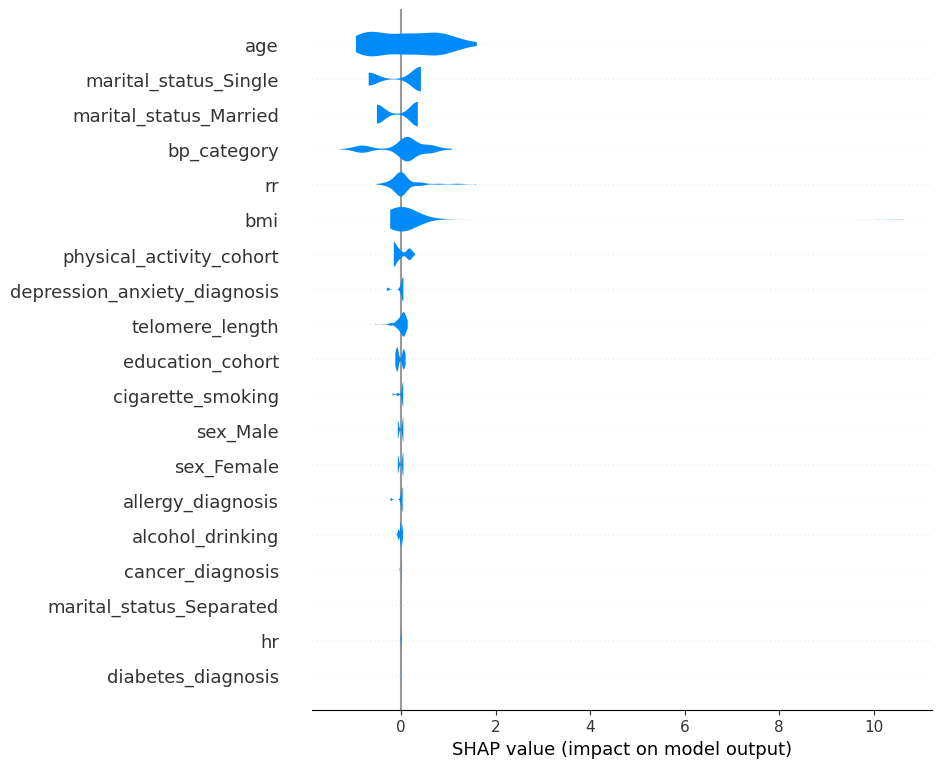

In [280]:
shap.plots.violin(cvd_shap_values, feature_names=cvd_feature_vw["Selected Features"])

In [281]:
def match_highlight(value):
    color = "green" if value == "Correct" else "red" if value == "Incorrect" else None
    return f"background-color: {color}; color: white"


cvd_prediction_df = cvd_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cvd_prediction_df = cvd_prediction_df.head(10).style.applymap(match_highlight)

display(styled_cvd_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Present,Present,50,Correct,74.68
1,Present,Present,62.07,Correct,
2,Absent,Present,47.13,Incorrect,
3,Present,Absent,16.55,Incorrect,
4,Present,Absent,15.65,Incorrect,
5,Absent,Absent,36.1,Correct,
6,Present,Absent,44.22,Incorrect,
7,Absent,Absent,5.88,Correct,
8,Present,Present,57.67,Correct,
9,Absent,Absent,14.05,Correct,


<h2 style="text-align:center">Cancer Prediction</h1>

In [282]:
cancer_df = read_data()
cancer_df_preprocessed = preprocess_data(cancer_df)

cancer_pipeline, cancer_feature_vw, cancer_shap_values, cancer_prediction_df = train_model(
    cancer_df_preprocessed, to_predict="cancer_diagnosis"
)

In [283]:
cancer_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,52.680000,2.784767e-04
1,age,71.000000,1.678448e-04
2,cigarette_smoking,0.419827,6.285467e-05
3,alcohol_drinking,0.653498,3.580851e-05
4,physical_activity_cohort,1.810767,7.169116e-05
5,education_cohort,3.292493,3.426550e-04
6,bmi,405.383779,-3.136861e-04
7,hr,105.635180,7.502719e-05
8,rr,3.883005,-2.471539e-05
9,bp_category,1.041187,4.711601e-05


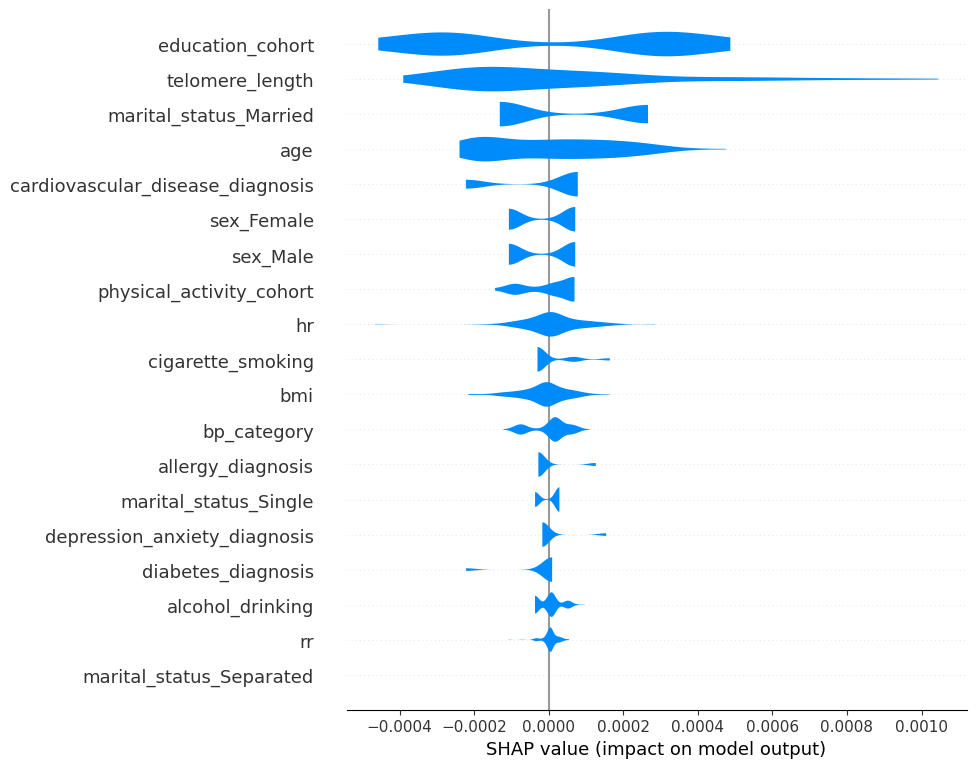

In [284]:
shap.plots.violin(cancer_shap_values, feature_names=cancer_feature_vw["Selected Features"])

In [285]:
cancer_prediction_df = cancer_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_cancer_prediction_df = cancer_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_cancer_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Present,Absent,16.19,Incorrect,83.12
1,Absent,Absent,16.2,Correct,
2,Absent,Absent,16.19,Correct,
3,Absent,Absent,16.19,Correct,
4,Present,Absent,16.21,Incorrect,
5,Absent,Absent,16.19,Correct,
6,Present,Absent,16.21,Incorrect,
7,Absent,Absent,16.19,Correct,
8,Present,Absent,16.19,Incorrect,
9,Absent,Absent,16.19,Correct,


<h2 style="text-align:center">Diabetes Mellitus Prediction</h1>

In [286]:
diabetes_df = read_data()
diabetes_df_preprocessed = preprocess_data(diabetes_df)

diabetes_pipeline, diabetes_feature_vw, diabetes_shap_values, diabetes_prediction_df = train_model(
    diabetes_df_preprocessed, to_predict="diabetes_diagnosis"
)

In [287]:
diabetes_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,52.840000,-2.786880e-04
1,age,79.000000,4.471521e-03
2,cigarette_smoking,0.424833,-7.428254e-03
3,alcohol_drinking,0.591480,3.148495e-03
4,physical_activity_cohort,1.734549,3.047779e-03
5,education_cohort,3.243463,4.470361e-03
6,bmi,405.193858,9.538576e-02
7,hr,102.338122,-5.100303e-03
8,rr,3.215400,-7.267567e-04
9,bp_category,1.061232,-1.658926e-03


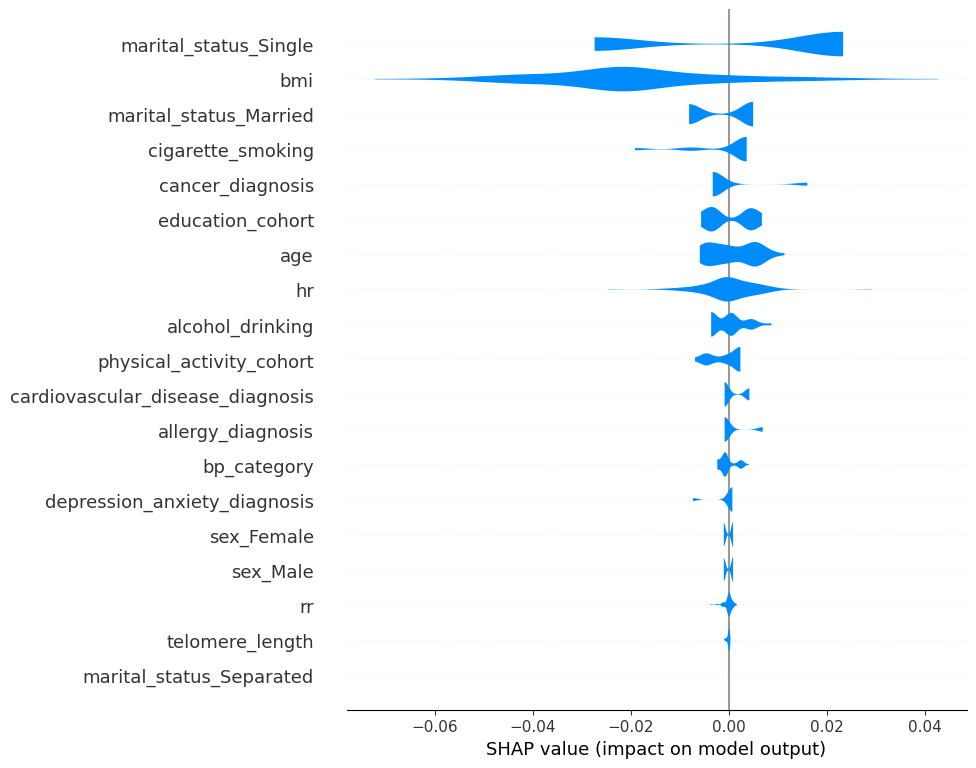

In [288]:
shap.plots.violin(diabetes_shap_values, feature_names=diabetes_feature_vw["Selected Features"])

In [289]:
diabetes_prediction_df = diabetes_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_diabetes_prediction_df = diabetes_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_diabetes_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,0.98,Correct,94.81
1,Absent,Absent,6.12,Correct,
2,Absent,Absent,0.95,Correct,
3,Absent,Absent,1.27,Correct,
4,Absent,Absent,4.14,Correct,
5,Absent,Absent,6.81,Correct,
6,Absent,Absent,5.27,Correct,
7,Absent,Absent,7.21,Correct,
8,Present,Absent,5.13,Incorrect,
9,Absent,Absent,7.55,Correct,


<h2 style="text-align:center">Depression/Anxiety Prediction</h1>

In [290]:
depression_anxiety_df = read_data()
depression_anxiety_df_preprocessed = preprocess_data(depression_anxiety_df)

(
    depression_anxiety_pipeline,
    depression_anxiety_feature_vw,
    depression_anxiety_shap_values,
    depression_anxiety_prediction_df,
) = train_model(
    depression_anxiety_df_preprocessed, to_predict="depression_anxiety_diagnosis"
)

In [291]:
depression_anxiety_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,38.750000,-0.095352
1,age,79.000000,-1.581859
2,cigarette_smoking,0.401720,-0.365343
3,alcohol_drinking,0.660283,0.289720
4,physical_activity_cohort,1.798919,-0.167748
5,education_cohort,3.278170,0.132198
6,bmi,405.640167,-0.493251
7,hr,113.000000,-0.272558
8,rr,3.719736,0.069034
9,bp_category,1.091337,0.206684


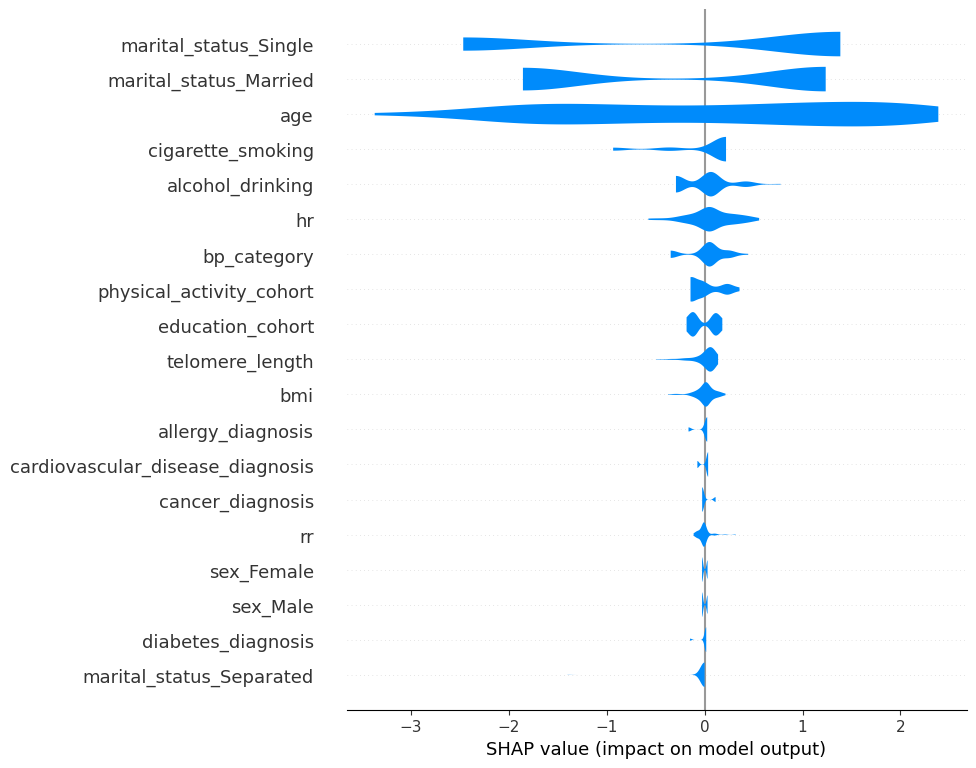

In [292]:
shap.plots.violin(depression_anxiety_shap_values, feature_names=depression_anxiety_feature_vw["Selected Features"])

In [293]:
depression_anxiety_prediction_df = depression_anxiety_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_depression_anxiety_prediction_df = depression_anxiety_prediction_df.head(
    10
).style.applymap(match_highlight)

display(styled_depression_anxiety_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,7.71,Correct,98.05
1,Absent,Absent,1.58,Correct,
2,Absent,Absent,8.66,Correct,
3,Absent,Absent,0.81,Correct,
4,Absent,Absent,1.25,Correct,
5,Absent,Absent,0.1,Correct,
6,Absent,Absent,0,Correct,
7,Absent,Absent,0.86,Correct,
8,Absent,Absent,0.66,Correct,
9,Absent,Absent,0.2,Correct,


<h2 style="text-align:center">Allergy Prediction</h1>

In [294]:
allergy_df = read_data()
allergy_df_preprocessed = preprocess_data(allergy_df)

(
    allergy_pipeline,
    allergy_feature_vw,
    allergy_shap_values,
    allergy_prediction_df,
) = train_model(allergy_df_preprocessed, to_predict="allergy_diagnosis")

In [295]:
allergy_feature_vw

,Selected Features,Variances,Weights
0,telomere_length,52.680000,-1.270816e-05
1,age,79.000000,-7.745120e-07
2,cigarette_smoking,0.416966,-5.635913e-05
3,alcohol_drinking,0.636379,1.030169e-05
4,physical_activity_cohort,1.736638,-1.061452e-05
5,education_cohort,3.263395,2.850958e-06
6,bmi,404.788075,-1.720779e-05
7,hr,107.000000,3.093321e-05
8,rr,4.068022,-2.365309e-05
9,bp_category,1.099374,8.066613e-06


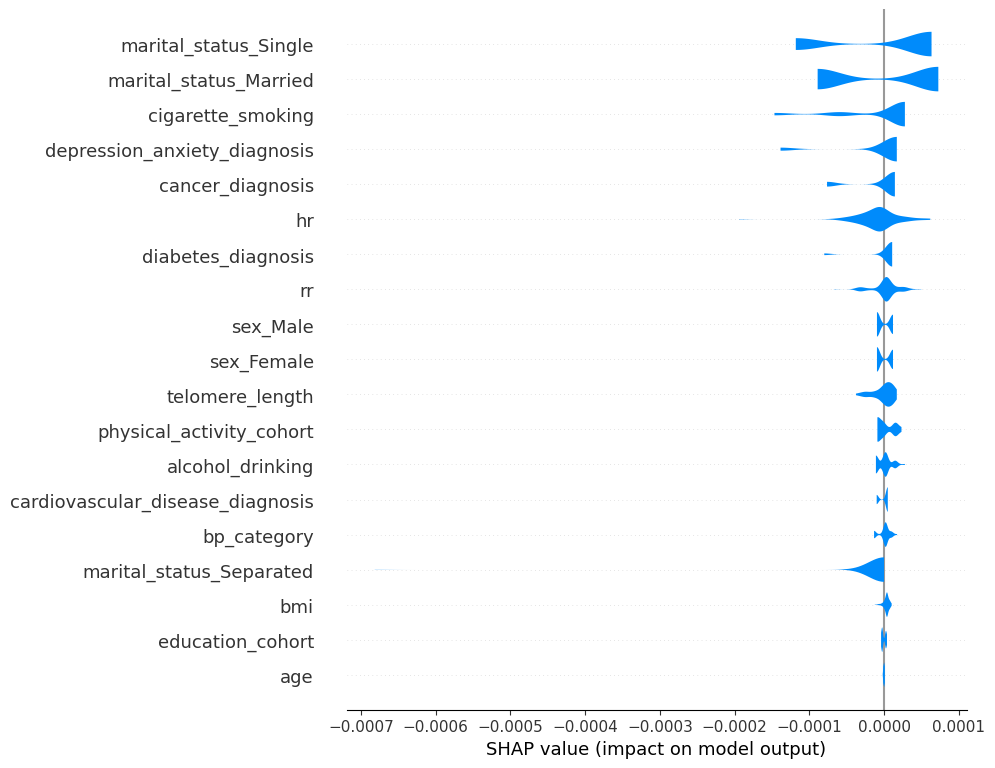

In [296]:
shap.plots.violin(allergy_shap_values, feature_names=allergy_feature_vw["Selected Features"])

In [297]:
allergy_prediction_df = allergy_prediction_df.applymap(
    lambda x: ("%.10g" % x) if isinstance(x, (int, float)) else x
)
styled_allergy_prediction_df = allergy_prediction_df.head(10).style.applymap(
    match_highlight
)

display(styled_allergy_prediction_df)

,Actual,Predicted,Probability (%),Match,Accuracy
0,Absent,Absent,13.81,Correct,88.31
1,Present,Absent,12.91,Incorrect,
2,Present,Absent,13.6,Incorrect,
3,Absent,Absent,13.1,Correct,
4,Present,Absent,13.83,Incorrect,
5,Absent,Absent,13.55,Correct,
6,Absent,Absent,13.6,Correct,
7,Absent,Absent,13.7,Correct,
8,Absent,Absent,13.3,Correct,
9,Absent,Absent,13.48,Correct,
